In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import RepeatedKFold

# optimization tools for lightgbm
!pip install optuna

import optuna
import optuna.integration.lightgbm as opt_lgb

# MODELS
import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from tensorflow.keras import Model, layers, callbacks
import lightgbm as lgb

# plot styling
plt.style.use('seaborn-darkgrid') # style
plt.rcParams.update({'font.size': 13}) # font size
plt_dpi = None # resolution

# global seed for reproducibility
RANDOM_STATE = 1337

USE_G_COLAB = True
if USE_G_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir("/content/drive/My Drive/AlgoTrading")
    !ls

In [ ]:
# read data
returns = pd.read_csv('DowJones_daily.csv')
returns.head()

,Date,AAPL,AXP,CAT,CSCO,CVX,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,TRV,UNH,VZ,WBA,WMT,XOM
0,1996-01-02,-0.003876,-0.003003,0.012766,0.025168,0.004751,-0.002632,-0.005472,0.021786,-0.014620,0.004274,0.010101,0.011111,0.022642,-0.007722,0.021337,0.034545,-0.004000,0.012177,0.015730,-0.005769,0.016886,0.008368,0.044944,0.004673
1,1996-01-03,0.003906,0.000000,0.016807,-0.029752,-0.007026,0.000000,-0.019231,-0.014925,0.027859,0.004274,0.006656,-0.005464,-0.009158,-0.013619,-0.025245,-0.028169,-0.004016,0.026987,0.017778,0.001931,0.027574,-0.008264,0.016216,0.000000
2,1996-01-04,-0.025096,-0.017910,-0.008264,-0.037479,0.025882,-0.002688,-0.025245,-0.021277,-0.008571,-0.040512,-0.008264,0.002740,-0.003697,0.007905,0.001433,-0.012658,0.027944,0.032641,0.015317,0.007692,-0.010811,-0.008368,0.005291,0.003082
3,1996-01-05,0.083004,-0.003040,0.016667,0.030631,0.018391,-0.005494,0.030523,0.006565,0.004342,-0.004444,-0.005000,-0.010989,0.000000,-0.007874,0.001449,-0.016729,-0.003922,0.004310,0.004320,-0.036398,0.016484,0.046809,0.000000,0.027735
4,1996-01-08,0.003623,0.000000,-0.004098,-0.011344,0.002252,-0.011236,0.005642,-0.008602,0.011511,-0.004444,0.006700,0.005571,-0.009242,0.013889,-0.002890,0.018939,0.011811,0.008621,0.000000,-0.019881,0.001818,-0.004082,0.010811,0.013514


## 1. Benchmark Strategies

Implement the following three benchmark strategies (used for comparison):  

• The market following strategy, where you each day go long $1 in each stock at open and sell at close 

• The momentum strategy, where you, each day, go long $1 in the stocks with a positive EWMA(20) and 
short in the stocks with a negative EWMA(20) and close out your positions at the close prices 

• The persistence strategy, where you each day go long \$1 in the stocks whose previous return was 
positive or zero and otherwise short $1, and close out your positions at the close prices 
 
Start the strategies at the 1001th day of the return data (to enable a comparison with the ML-strategies) and 

In [57]:
# Extract data from the 1001 day and forward (backtesting period)
benchmark_returns = returns.iloc[1000:, :]

# Extract EWMA based on the whole time period 
ewma20 = returns.ewm(span=20).mean().shift(1)
ewma60 = returns.ewm(span=60).mean().shift(1)

In [58]:
# Implementing the market following strategy as a function 
def market_follow(returns, V):
  
  # Extract precision of startegy
  precision = np.mean(np.ones(returns.shape[0]) == np.sign(returns))

  return V + np.sum(returns), precision

In [59]:
# Implementing the momentum strategy
def momentum(returns, V, ewma20):

  # Get index for stocks having positive ewma
  index_long = ewma20 > 0
  returns_long = returns * index_long

  # Get index for stocks having negative ewma
  index_short = ewma20 < 0
  returns_short = -returns * index_short

  # Summerize returns and extract new portfolio value
  returns_strat = returns_long + returns_short

  precision = np.mean(np.sign(returns_strat) == np.sign(returns))

  return V + np.sum(returns_strat), precision

In [60]:
# Implementing the persistence strategy
def persistance(returns, V, previous_returns):

  # Get index for stocks having positive previous return
  index_long = previous_returns >= 0
  returns_long = returns * index_long

  # Get index for stocks having negative previous
  index_short = previous_returns < 0
  returns_short = -returns * index_short

  # Summerize returns and extract new portfolio value
  returns_strat = returns_long + returns_short

  precision = np.mean(np.sign(returns_strat) == np.sign(returns))

  return V + np.sum(returns_strat), precision

In [61]:
# Main script for calling the strategies over the backtesting period

# Initialize value of portfolio
V_market_follow = np.zeros(benchmark_returns.shape[0] + 1)
V_market_follow[0] = benchmark_returns.shape[1] - 1
Precision_market_follow = np.zeros(benchmark_returns.shape[0])

V_momentum = np.zeros(benchmark_returns.shape[0] + 1)
V_momentum[0] = benchmark_returns.shape[1] - 1 
Precision_momentum = np.zeros(benchmark_returns.shape[0])

V_persistance = np.zeros(benchmark_returns.shape[0] + 1)
V_persistance[0] = benchmark_returns.shape[1] - 1 
Precision_persistance = np.zeros(benchmark_returns.shape[0])

# Counter
i = 1

# Iterate over returns 
for index, Returns in benchmark_returns.iterrows():

  # Extract returns needed for calculation of portfolio value 
  Returns = Returns.values[1:].astype(float)

  # Extract previous returns needed for calculation of portfolio value 
  previous_returns = returns.iloc[index - 1, 1:].astype(float)

  # market following strategy
  V_market_follow[i], Precision_market_follow[i - 1] = market_follow(Returns, V_market_follow[i - 1])

  # momentum strategy
  V_momentum[i], Precision_momentum[i - 1] = momentum(Returns, V_momentum[i - 1], ewma20.iloc[index,:])

  # persistance strategy
  V_persistance[i], Precision_persistance[i - 1] = persistance(Returns, V_persistance[i - 1], previous_returns)
  
  # counter
  i = i + 1

a) Plot the evolution of these strategies

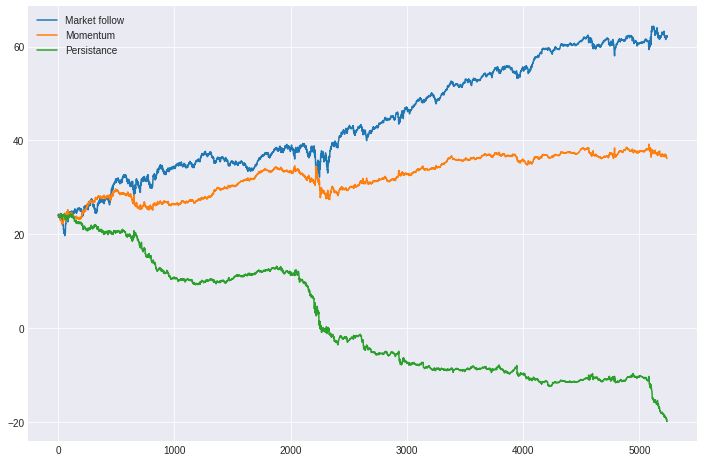

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(V_market_follow)
plt.plot(V_momentum)
plt.plot(V_persistance)
plt.legend(['Market follow', 'Momentum', 'Persistance'])
plt.show()

b) Include a table with the values of the benchmark strategies every 250th day, beginning at day 0 

In [63]:
# Summerize the results in a new Dataframe
T = benchmark_returns.shape[0] + 1
res = {
    'Day': np.arange(T),
    'Market follow': V_market_follow,
    'Momentum': V_momentum,
    'Persistance': V_persistance
}
res_2a = pd.DataFrame(res).set_index('Day')

In [64]:
# Extract and present the values of the strategies every 250th day
idx = res_2a.index % 250 == 0
res_2b = res_2a.iloc[idx].round(2)
res_2b

,Market follow,Momentum,Persistance
Day,,,
0,24.00,24.00,24.00
250,25.90,25.64,20.76
500,31.02,29.29,20.43
750,31.83,25.90,15.96
1000,34.20,26.36,10.63
1250,36.81,27.57,9.80
1500,35.44,30.31,10.50
1750,36.68,33.39,11.99
2000,38.35,33.17,11.55


c) Produce a table showing the strategies’ annualized means, volatilities and Sharpe ratios based on 
differences, not returns. Also include the win percentages and average precisions

In [2]:
def get_annualized_mean(e):
    returns = (e[1:] - e[:-1])
    return np.mean(returns) * 252

In [3]:
def get_annualized_volatility(e):
    returns = (e[1:] - e[:-1]) 
    return np.std(returns) * np.sqrt(252)

In [4]:
def get_sharpe(e):
    R = (e[1:] - e[:-1]) 
    return np.sqrt(252) * np.mean(R) / np.std(R)

In [5]:
def get_win_percentage(e):
  return np.mean(e > 0) * 100.0

In [134]:
# define strategy lists
strategy_labels = [
   'Market follow',
    'Momentum',
    'Persistance'
]
strategies = [V_market_follow, V_momentum, V_persistance]
differences = [np.diff(V_market_follow), np.diff(V_momentum), np.diff(V_persistance)]
precisions = [Precision_market_follow, Precision_momentum, Precision_persistance]

# create dict and df
res = {
    'Strategy': strategy_labels,
    'Mean': [get_annualized_mean(e) for e in strategies],
    'Volatility': [get_annualized_volatility(e) for e in strategies],
    'Sharpe Ratio': [get_sharpe(e) for e in strategies],
    'Win percentage': [get_win_percentage(diff) for diff in differences],
    'Average precision':[np.mean(pre) * 100 for pre in precisions]
}
df_2c = pd.DataFrame(res).set_index('Strategy').round(4)

# print results
df_2c

,Mean,Volatility,Sharpe Ratio,Win percentage,Average precision
Strategy,,,,,
Market follow,1.8428,3.6061,0.5110,54.4396,50.6357
Momentum,0.5851,2.2359,0.2617,53.1602,56.4008
Persistance,-2.1092,2.2942,-0.9193,49.5131,51.8872


## 2. Linear regression and decision tree strategies  

Backtest linear regression and two decision tree classifiers, with maximum depths 2 and 3 respectively. 


In [66]:
# Define training data and labels
train_ewma20 = ewma20.dropna()
train_ewma60 = ewma60.dropna()
X_train = np.concatenate((train_ewma20, train_ewma60), axis = 1)

Y_train = returns.iloc[1:,1:]

In [67]:
# Linear regression and Decision trees

T = Y_train.shape[0]
t = 0

from sklearn.linear_model import LinearRegression
regression_returns = np.zeros(T-1000)
regression_precision = np.zeros(T-1000)
V_regression = Y_train.shape[1]

from sklearn.tree import DecisionTreeClassifier
tree_returns_2 = np.zeros(T-1000)
tree_precision_2 = np.zeros(T-1000)
V_tree_2 = Y_train.shape[1]

tree_returns_3 = np.zeros(T-1000)
tree_precision_3 = np.zeros(T-1000)
V_tree_3 = Y_train.shape[1]

for i in np.arange(1000, T, 250):

  # Define training data for timestep
  start = i - 1000
  x_train = X_train[start:i]
  y_train = Y_train[start:i]

  # Define test data for timestep
  end = i + 250
  x_test = X_train[i:end]
  y_test = Y_train[i:end]

  # DECISION TREES

  y_train_tree = np.sign(y_train)

  # Convert y_pred = 0 to y_pred = 1
  y_train_tree[y_train_tree == 0] = 1

  y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
  y_pred_2 = np.zeros((y_test.shape[0],y_test.shape[1]))
  y_pred_3 = np.zeros((y_test.shape[0],y_test.shape[1]))

  # Definde models 
  clf_tree_2 = DecisionTreeClassifier(
      max_depth=2,
      random_state=RANDOM_STATE
  )
  clf_tree_3 = DecisionTreeClassifier(
      max_depth=3,
      random_state=RANDOM_STATE
    )
  clf_lr = LinearRegression()

  for stock in range(24):

    # LINEAR REGRESSION

    # Train linear regresion model
    clf_lr.fit(x_train, y_train.values[:,stock])

    # Predict future returns
    y_pred[:,stock] = np.sign(clf_lr.predict(x_test))

    # Train decision tree models
    clf_tree_2.fit(x_train, y_train_tree.values[:,stock])

    clf_tree_3.fit(x_train, y_train_tree.values[:,stock])

    # Predict future returns
    y_pred_2[:,stock] = clf_tree_2.predict(x_test)

    y_pred_3[:,stock] = clf_tree_3.predict(x_test)

    if stock == 0:
      clf_tree_2_AAPL = DecisionTreeClassifier(max_depth=2)
      clf_tree_2_AAPL.fit(x_train, y_train_tree.values[:,stock])

  # Convert y_pred = 0 to y_pred = 1
  y_pred[y_pred == 0] = 1

  # Get allocation for each timestep
  start = i - 1000
  end = start + 250
  ret = np.sum(y_pred * y_test, axis = 1)
  regression_returns[start:end] = ret

  # Get precision for each timestep
  regression_precision[start:end] = np.mean(y_pred == np.sign(y_test), axis = 1)

  # Get allocation for each timestep
  ret2 = np.sum(y_pred_2 * y_test, axis = 1)
  tree_returns_2[start:end] = ret2

  ret3 = np.sum(y_pred_3 * y_test, axis = 1)
  tree_returns_3[start:end] = ret3

  # Get precision for each timestep
  tree_precision_2[start:end] = np.mean(y_pred_2 == np.sign(y_test), axis = 1)

  tree_precision_3[start:end] = np.mean(y_pred_3 == np.sign(y_test), axis = 1)

V_regression = V_regression + np.cumsum(regression_returns)
V_tree_2 = V_tree_2 + np.cumsum(tree_returns_2)
V_tree_3 = V_tree_3 + np.cumsum(tree_returns_3)

a) Plot the evolution of these strategies in the same plot as the benchmark strategies 

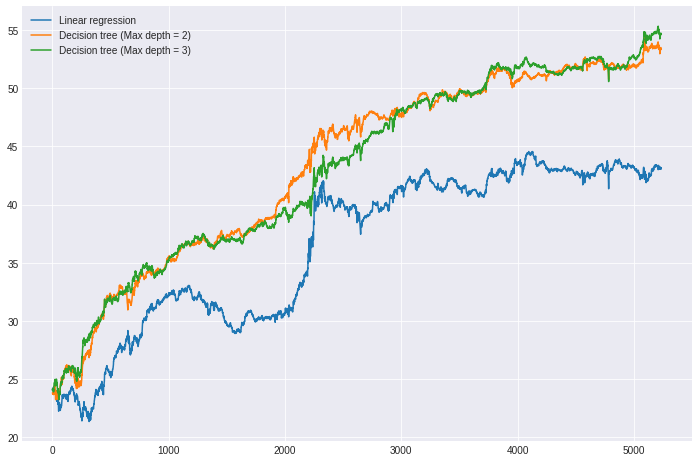

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(V_regression, label = 'Linear regression')
plt.plot(V_tree_2, label = 'Decision tree (Max depth = 2)')
plt.plot(V_tree_3, label = 'Decision tree (Max depth = 3)')
plt.legend()
plt.show()

b) Include the strategies’ values in the every 250th day table  

In [119]:
# Summerize the results in a new Dataframe
T = V_regression.shape[0]
res = {
    'Day': np.arange(T),
    'Linear regression': V_regression,
    'Decision tree (Max depth = 2)': V_tree_2,
    'Decision tree (Max depth = 3)': V_tree_3
}
res_3a = pd.DataFrame(res).set_index('Day')

In [120]:
# Extract and present the values of the strategies every 250th day
idx = res_3a.index % 250 == 0
res_3b = res_3a.iloc[idx].round(2)
res_3b.iloc[0,:] = Y_train.shape[1]
res_3b

,Linear regression,Decision tree (Max depth = 2),Decision tree (Max depth = 3)
Day,,,
0,24.00,24.00,24.00
250,21.86,24.72,26.14
500,25.38,32.23,32.05
750,28.42,33.69,34.04
1000,32.14,35.32,35.14
1250,32.17,36.93,37.26
1500,29.77,37.34,36.96
1750,30.03,38.33,37.88
2000,30.65,40.61,39.58


c) Include these strategies in the table with annualized means, volatilities, Sharpe ratios and win 
percentages. Also include the average precisions of these strategies 

In [129]:
# define strategy lists
strategy_labels = [
    'Linear regression',
    'Decision tree (Max depth = 2)',
    'Decision tree (Max depth = 3)'
]
strategies = [V_regression, V_tree_2, V_tree_3]
differences = [np.diff(V_regression), np.diff(V_tree_2), np.diff(V_tree_3)]
precisions = [regression_precision, tree_precision_2, tree_precision_3]

# create dict and df
res = {
    'Strategy': strategy_labels,
    'Mean': [get_annualized_mean(e) for e in strategies],
    'Volatility': [get_annualized_volatility(e) for e in strategies],
    'Sharpe Ratio': [get_sharpe(e) for e in strategies],
    'Win percentage': [get_win_percentage(diff) for diff in differences],
    'Average precision':[np.mean(pre) * 100 for pre in precisions]
}
df_3c = pd.DataFrame(res).set_index('Strategy').round(4)

# print results
df_3c

,Mean,Volatility,Sharpe Ratio,Win percentage,Average precision
Strategy,,,,,
Linear regression,0.9175,1.9650,0.4669,50.1624,49.7971
Decision tree (Max depth = 2),1.4230,1.5644,0.9096,51.9580,50.1958
Decision tree (Max depth = 3),1.4709,1.5006,0.9802,51.5568,50.2825


d) Plot the last decision tree, for Apple, with maximum depth 2 

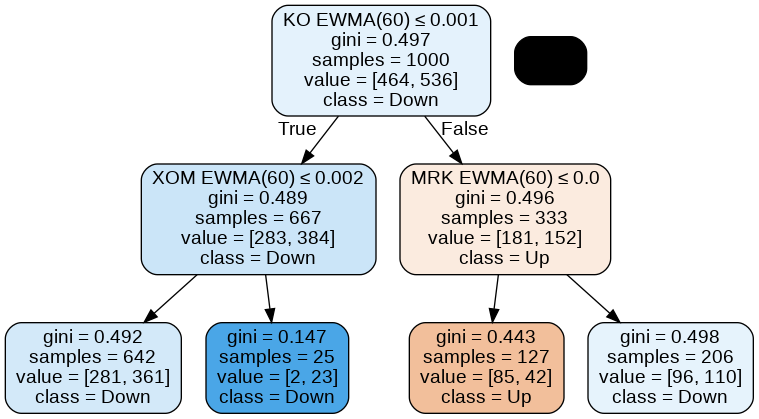

In [72]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

feature_cols = [*[e + ' EWMA(20)' for e in returns.columns.values[1:]] , *[e + ' EWMA(60)' for e in returns.columns.values[1:]]]

dot_data = StringIO()
export_graphviz(clf_tree_2_AAPL, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['Up', 'Down'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('default.png')
Image(graph.create_png())

## 3. Random Forest strategies

Backtest two random forest strategies: 

• Random forest classifier with 100 trees and maximum depth 3 

• Random forest classifier with 500 trees and maximum depth 5 
 

In [73]:
# data
returns = pd.read_csv('DowJones_daily.csv')
ewma20 = returns.ewm(span=20).mean().shift(1).dropna()
ewma60 = returns.ewm(span=60).mean().shift(1).dropna()
X_train = np.concatenate((ewma20, ewma60), axis=1)
Y_train = returns.iloc[1:,1:].values

In [74]:
# discretize labels
Y_train_RF = np.sign(Y_train)
Y_train_RF[Y_train_RF == 0.0] = 1.0

In [75]:
# extract initial training data
x_train_init = X_train[:1000]
y_train_init = Y_train_RF[:1000]
print('x init:', x_train_init.shape)
print('y init:', y_train_init.shape)

x init: (1000, 48)
y init: (1000, 24)


In [76]:
n_splits = np.round(X_train[1000:].shape[0] / 250.0)
retrain_step = 250

# split prediction data into batches
x_test = np.array_split(
    X_train[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

# discretized labels
y_test = np.array_split(
    Y_train_RF[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

# batched original returns
y_test_ret = np.array_split(
    Y_train[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

print('x test batch:', x_test[0].shape)
print('y test batch:', y_test[0].shape)

x test batch: (250, 48)
y test batch: (250, 24)


In [77]:
# create training batches
x_retrain, y_retrain = [], []
size = 1000
step = 250
for i in np.arange(step, 5250, step):
    x_retrain.append(X_train[i:size + i])
    y_retrain.append(Y_train_RF[i:size + i])

print('x retrain batch:', x_retrain[0].shape)
print('y retrain batch:', y_retrain[0].shape)

x retrain batch: (1000, 48)
y retrain batch: (1000, 24)


In [78]:
# for reproducibility
np.random.seed(RANDOM_STATE)

# train models initially
M1, M2 = [], []
for stock in np.arange(y_train_init.shape[1]):
    # model 1
    RF_1 = RandomForestClassifier(
        max_depth=3,
        n_estimators=100,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    RF_1 = RF_1.fit(x_train_init, y_train_init[:, stock])
    M1.append(RF_1)

    # model 2
    RF_2 = RandomForestClassifier(
        max_depth=5,
        n_estimators=500,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    RF_2 = RF_2.fit(x_train_init, y_train_init[:, stock])
    M2.append(RF_2)

In [ ]:
# for reproducibility
np.random.seed(RANDOM_STATE)

# allocation
RF_returns_1, RF_returns_2 = [], []
RF_precision_1, RF_precision_2 = [], []
V_RF_1, V_RF_2 = Y_train.shape[1], Y_train.shape[1]

# predict and retrain models
for batch in np.arange(len(x_test)):
    y_pred_1 = np.zeros(y_test[batch].shape)
    y_pred_2 = np.zeros(y_test[batch].shape)

    for stock in np.arange(y_train_init.shape[1]):
        # perform predictions
        y_pred_1[:, stock] = M1[stock].predict(x_test[batch])
        y_pred_2[:, stock] = M2[stock].predict(x_test[batch])

        # do not retrain model on the last batch
        if batch != len(x_test) - 1:
            print(f'\nBatch {batch + 1} of {len(x_test) - 1}')
            print(f'Stock {stock + 1} of {y_train_init.shape[1]}')
            print('---------------------------------------------')

            # retrain models
            print('Retraining model 1')
            M1[stock].fit(
                x_retrain[batch],
                y_retrain[batch][:, stock]
            )

            print('Retraining model 2')
            M2[stock].fit(
                x_retrain[batch],
                y_retrain[batch][:, stock],
            )
    
    # compute returns
    RF_returns_1.append(np.sum(y_pred_1 * y_test_ret[batch], axis=1))
    RF_returns_2.append(np.sum(y_pred_2 * y_test_ret[batch], axis=1))

    # compute precisions
    RF_precision_1.append(np.mean(y_pred_1 == y_test[batch], axis=1))
    RF_precision_2.append(np.mean(y_pred_2 == y_test[batch], axis=1))

print('\nDone...')

# format precisions
RF_precision_1 = np.concatenate(RF_precision_1)
RF_precision_2 = np.concatenate(RF_precision_2)

# compute portfolio evolution
V_RF_1 = V_RF_1 + np.cumsum(
    np.concatenate(RF_returns_1)
)
V_RF_2 = V_RF_2 + np.cumsum(
    np.concatenate(RF_returns_2)
)

a) Plot the evolution of these strategies in the same plot as the previous strategies 

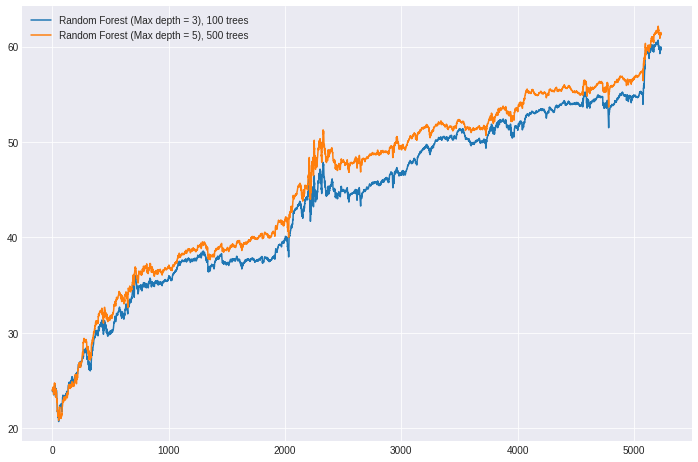

In [80]:
plt.figure(figsize=(12, 8))
plt.plot(V_RF_1, label = 'Random Forest (Max depth = 3), 100 trees')
plt.plot(V_RF_2, label = 'Random Forest (Max depth = 5), 500 trees')
plt.legend()
plt.show()

b) Include the strategies’ values in the every 250th day table  

In [121]:
# Summerize the results in a new Dataframe
T = V_RF_1.shape[0]
res = {
    'Day': np.arange(T),
    'Random Forest (Max depth = 3), 100 trees': V_RF_1,
    'Random Forest (Max depth = 5), 500 trees': V_RF_2
}
res_4a = pd.DataFrame(res).set_index('Day')

In [122]:
# Extract and present the values of the strategies every 250th day
idx = res_4a.index % 250 == 0
res_4b = res_4a.iloc[idx].round(2)
res_4b.iloc[0,:] = Y_train.shape[1]
res_4b

,"Random Forest (Max depth = 3), 100 trees","Random Forest (Max depth = 5), 500 trees"
Day,,
0,24.00,24.00
250,26.86,26.86
500,30.19,31.80
750,34.77,36.27
1000,35.72,36.82
1250,38.13,39.16
1500,37.26,38.81
1750,37.56,39.90
2000,39.82,41.80


c) Include these strategies in the table with annualized means, volatilities, Sharpe ratios, win percentages 
and average precisions

In [130]:
# define strategy lists
strategy_labels = [
    'Random Forest (Max depth = 3), 100 trees',
    'Random Forest (Max depth = 5), 500 trees'
]
strategies = [V_RF_1, V_RF_2]
differences = [np.diff(V_RF_1), np.diff(V_RF_2)]
precisions = [RF_precision_1, RF_precision_2]

# create dict and df
res = {
    'Strategy': strategy_labels,
    'Mean': [get_annualized_mean(e) for e in strategies],
    'Volatility': [get_annualized_volatility(e) for e in strategies],
    'Sharpe Ratio': [get_sharpe(e) for e in strategies],
    'Win percentage': [get_win_percentage(diff) for diff in differences],
    'Average precision':[np.mean(pre) * 100 for pre in precisions]
}
df_4c = pd.DataFrame(res).set_index('Strategy').round(4)

# print results
df_4c

,Mean,Volatility,Sharpe Ratio,Win percentage,Average precision
Strategy,,,,,
"Random Forest (Max depth = 3), 100 trees",1.7273,2.3966,0.7207,52.9131,51.0067
"Random Forest (Max depth = 5), 500 trees",1.7939,2.5215,0.7115,52.7412,50.9382


## 4. Neural network strategies 

• One hidden layer with 15 nodes and sigmoid activation function. Apply dropout with rate 0.2  

• Two hidden layers with 15 and 5 nodes respectively and sigmoid activations. Apply dropout to both 
hidden layers with rate 0.2

Let the output node have a linear activation. Train for 1000 epochs with a batch size of 100. 

In [42]:
class NeuralNetOne(Model):
    def __init__(self, name=None):
        super(NeuralNetOne, self).__init__(name=name)
        self.dense_1 = layers.Dense(
            15,
            activation='sigmoid',
            name='dense_1'
        )
        self.dropout_1 = layers.Dropout(
            0.2,
            name='dropout_1'
        )
        self.out = layers.Dense(
            1,
            activation='linear',
            name='output'
        )

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dropout_1(x)
        return self.out(x)

    def get_compile(self):
        self.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mse']
        )

    def get_summary(self):
        x = layers.Input(
            shape=(48, ),
            name='input'
        )
        return Model(
            inputs=[x],
            outputs=self.call(x),
            name=self.name
        ).summary()

    def get_fit(self, x_train, y_train, epochs=1000, verbose=0, patience=100):
        self.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=100,
            verbose=verbose,
            callbacks=[
                callbacks.EarlyStopping(
                    monitor='loss',
                    patience=patience,
                    min_delta=1e-5,
                    verbose=1,
                    restore_best_weights=True
                )
            ]
        )

class NeuralNetTwo(NeuralNetOne):
    def __init__(self, name=None):
        super(NeuralNetTwo, self).__init__(name=name)
        self.dense_2 = layers.Dense(
            5,
            activation='sigmoid',
            name='dense_2'
        )
        self.dropout_2 = layers.Dropout(
            0.2,
            name='dropout_2'
        )

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        return self.out(x)

In [43]:
# data
returns = pd.read_csv('DowJones_daily.csv')
ewma20 = returns.ewm(span=20).mean().shift(1).dropna()
ewma60 = returns.ewm(span=60).mean().shift(1).dropna()
X_train = np.concatenate((ewma20, ewma60), axis=1)
Y_train = returns.iloc[1:, 1:].values

In [44]:
# extract initial training data
x_train_init = X_train[:1000]
y_train_init = Y_train[:1000]
print('x init:', x_train_init.shape)
print('y init:', y_train_init.shape)

x init: (1000, 48)
y init: (1000, 24)


In [45]:
n_splits = np.round(X_train[1000:].shape[0] / 250.0)
retrain_step = 250

# split retrain data into batches
x_retrain = np.array_split(
    X_train[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

y_retrain = np.array_split(
    Y_train[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

print('x retrain batch:', x_retrain[0].shape)
print('y retrain batch:', y_retrain[0].shape)

x retrain batch: (250, 48)
y retrain batch: (250, 24)


In [48]:
# test model 1
m1 = NeuralNetOne(name='model_1-test')
m1.get_summary()
m1.get_compile()
h1 = m1.get_fit(
    x_train_init,
    y_train_init[:, 0],
    epochs=1,
    patience=1,
    verbose=2
)
r1 = m1.predict(x_retrain[0])

Model: "model_1-test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48)]              0         
                                                                 
 dense_1 (Dense)             (None, 15)                735       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 output (Dense)              (None, 1)                 16        
                                                                 
Total params: 751
Trainable params: 751
Non-trainable params: 0
_________________________________________________________________
10/10 - 0s - loss: 0.4098 - mse: 0.4098 - 469ms/epoch - 47ms/step


In [49]:
# test model 2
m2 = NeuralNetTwo(name='model_2-test')
m2.get_summary()
m2.get_compile()
h2 = m2.get_fit(
    x_train_init,
    y_train_init[:, 0],
    epochs=1,
    verbose=2
)
r2 = m2.predict(x_retrain[0])

Model: "model_2-test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48)]              0         
                                                                 
 dense_1 (Dense)             (None, 15)                735       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 80        
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 821
Trainable params: 821
Non-trainable 

In [ ]:
# for reproducibility
tensorflow.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# create models and perform initial training
M1, M2 = [], []
for i in np.arange(Y_train.shape[1]):
    print(f'\n\nModel set {i + 1} of {Y_train.shape[1]}')
    print('--------------------------------------------')

    # model 1
    print('Fitting model 1')
    m1 = NeuralNetOne(name=f"model_1-{i + 1}")
    m1.get_compile()
    m1.get_fit(
        x_train_init,
        y_train_init[:, i]
    )
    M1.append(m1)

    # model 2
    print('\nFitting model 2')
    m2 = NeuralNetTwo(name=f"model_2-{i + 1}")
    m2.get_compile()
    m2.get_fit(
        x_train_init,
        y_train_init[:, i]
    )
    M2.append(m2)
print('\nDone...')

In [52]:
# save pre-trained models
for i in np.arange(y_train_init.shape[1]):
    M1[i].save_weights(f'pretrained_m1/model_1-{i + 1}')
    M2[i].save_weights(f'pretrained_m2/model_2-{i + 1}')
clear_output()

In [ ]:
# load pre-trained models
M1, M2 = [], []
for i in np.arange(Y_train.shape[1]):
    print(f'\nLoading model set {i + 1} of {Y_train.shape[1]}')
    print('--------------------------------------------')

    # model 1
    m1 = NeuralNetOne(name=f"model_1-{i + 1}")
    m1.load_weights(f'pretrained_m1/model_1-{i + 1}')
    m1.get_compile()
    M1.append(m1)

    # model 2
    m2 = NeuralNetTwo(name=f"model_2-{i + 1}")
    m2.load_weights(f'pretrained_m2/model_2-{i + 1}')
    m2.get_compile()
    M2.append(m2)
print('\nDone...')
clear_output()

In [ ]:
# for reproducibility
tensorflow.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# allocation
NN_returns_1, NN_precision_1 = list(), list() 
NN_returns_2, NN_precision_2 = list(), list()
V_NN_1, V_NN_2 = Y_train.shape[1], Y_train.shape[1] 

# predict and retrain models
for batch in np.arange(len(x_retrain)):
    # allocate predictions
    y_pred_1 = np.zeros(y_retrain[batch].shape)
    y_pred_2 = np.zeros(y_retrain[batch].shape)

    for stock in np.arange(y_train_init.shape[1]):
        # perform predictions
        y_pred_1[:, stock] = np.where(
            M1[stock].predict(x_retrain[batch]) >= 0.0, 1.0, -1.0
        ).flatten()

        y_pred_2[:, stock] = np.where(
            M2[stock].predict(x_retrain[batch]) >= 0.0, 1.0, -1.0
        ).flatten()

        # do not retrain model on the last batch
        if batch != len(x_retrain) - 1:
            print(f'\n\nBatch {batch + 1} of {len(x_retrain) - 1}')
            print(f'Stock {stock + 1} of {y_train_init.shape[1]}')
            print('---------------------------------------------')

            # retrain models
            print(f'Fitting model 1')
            M1[stock].get_fit(
                x_retrain[batch],
                y_retrain[batch][:, stock],
                epochs=250,
                patience=25
            )

            print(f'\nFitting model 2')
            M2[stock].get_fit(
                x_retrain[batch],
                y_retrain[batch][:, stock],
                epochs=250,
                patience=25
            )

    # compute returns
    NN_returns_1.append(np.sum(y_pred_1 * y_retrain[batch], axis=1))
    NN_returns_2.append(np.sum(y_pred_2 * y_retrain[batch], axis=1))

    # compute precision
    y_retrain_sign = np.where(y_retrain[batch] >= 0.0, 1.0, -1.0)
    NN_precision_1.append(
        np.mean(
            y_pred_1 == y_retrain_sign,
            axis=1
        )
    )
    NN_precision_2.append(
        np.mean(
            y_pred_2 == y_retrain_sign,
            axis=1
        )
    )
print('\nDone...')

# format precisions
NN_precision_1 = np.concatenate(NN_precision_1)
NN_precision_2 = np.concatenate(NN_precision_2)

# compute portfolio evolution
V_NN_1 = V_NN_1 + np.cumsum(
    np.concatenate(NN_returns_1)
)
V_NN_2 = V_NN_2 + np.cumsum(
    np.concatenate(NN_returns_2)
)

In [54]:
test1 = np.where(M1[stock].predict(x_retrain[batch]) >= 0.0, 1.0, -1.0).flatten()
test2 = np.sign(M1[stock].predict(x_retrain[batch])).flatten()
test2[test2 == 0.0] = 1.0
np.mean(test1 == test2)

1.0

a) Plot the evolution of these strategies in the same plot as the previous strategies 

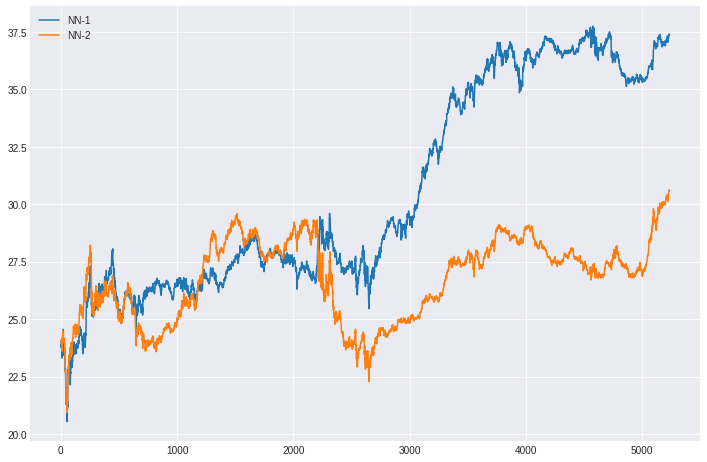

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(V_NN_1, label='NN-1')
plt.plot(V_NN_2, label='NN-2')
plt.legend()
plt.show()

b) Include the strategies’ values in the every 250th day table  

In [123]:
T = V_regression.shape[0]
res = {
    'Day': np.arange(T),
    'NN-1': V_NN_1,
    'NN-2': V_NN_2
}
res_5a = pd.DataFrame(res).set_index('Day')

In [124]:
# Extract and present the values of the strategies every 250th day
idx = res_5a.index % 250 == 0
res_5b = res_5a.iloc[idx].round(2)
res_5b.iloc[0,:] = Y_train.shape[1]
res_5b

,NN-1,NN-2
Day,,
0,24.00,24.00
250,26.72,27.87
500,25.10,24.90
750,26.34,24.09
1000,26.74,25.06
1250,26.98,27.75
1500,27.65,29.34
1750,27.24,27.58
2000,27.40,28.92


c) Include these strategies in the table with annualized means, volatilities, Sharpe ratios, win percentages 
and average precisions

In [131]:
# define strategy lists
strategy_labels = [
    'NN-1',
    'NN-2'
]
strategies = [V_NN_1, V_NN_2]
differences = [np.diff(V_NN_1), np.diff(V_NN_2)]
precisions = [NN_precision_1, NN_precision_2]

# create dict and df
res = {
    'Strategy': strategy_labels,
    'Mean': [get_annualized_mean(e) for e in strategies],
    'Volatility': [get_annualized_volatility(e) for e in strategies],
    'Sharpe Ratio': [get_sharpe(e) for e in strategies],
    'Win percentage': [get_win_percentage(diff) for diff in differences],
    'Average precision':[np.mean(pre) * 100 for pre in precisions]
}
df_5c = pd.DataFrame(res).set_index('Strategy').round(4)

# print results
df_5c

,Mean,Volatility,Sharpe Ratio,Win percentage,Average precision
Strategy,,,,,
NN-1,0.6510,1.7426,0.3736,52.3209,50.6844
NN-2,0.3133,1.6241,0.1929,51.3085,50.5722


## 5. Your own strategy


### LightGBM

In [86]:
# data
returns = pd.read_csv('DowJones_daily.csv')
ewma20 = returns.ewm(span=20).mean().shift(1).dropna()
ewma60 = returns.ewm(span=60).mean().shift(1).dropna()
X_train = np.concatenate((ewma20, ewma60), axis=1)
Y_train = returns.iloc[1:,1:].values

In [87]:
# extract initial training data
x_train_init = X_train[:1000]
y_train_init = np.where(Y_train[:1000] >= 0.0, 1.0, -1.0)
print('x init:', x_train_init.shape)
print('y init:', y_train_init.shape)

x init: (1000, 48)
y init: (1000, 24)


In [88]:
n_splits = np.round(X_train[1000:].shape[0] / 250.0)
retrain_step = 250

# split prediction data into batches
x_test = np.array_split(
    X_train[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

# discretized labels
y_test = np.array_split(
    np.where(Y_train[1000:] >= 0.0, 1.0, -1.0),
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

# batched original returns
y_test_ret = np.array_split(
    Y_train[1000:],
    np.arange(
        retrain_step,
        int(n_splits * retrain_step),
        step=retrain_step),
    axis=0
)

print('x test batch:', x_test[0].shape)
print('y test batch:', y_test[0].shape)

x test batch: (250, 48)
y test batch: (250, 24)


In [ ]:
def get_tuned_params(train_data):
    # define params
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': RANDOM_STATE
    }

    # create tuner
    study_tuner = optuna.create_study(direction='minimize')
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # tuner object
    tuner = opt_lgb.LightGBMTunerCV(
        params,
        train_data,
        study=study_tuner,
        verbose_eval=False,
        early_stopping_rounds=50,
        time_budget=None,
        seed=RANDOM_STATE,
        num_boost_round=500,
        callbacks=[
            opt_lgb.reset_parameter(
                learning_rate=[0.005] * 100 + [0.0025] * 100 + [0.001] * 300 
            )
        ]
    )
    tuner.run()
    return tuner

In [ ]:
# training data
mdl_params = dict()
for stock in np.arange(y_train_init.shape[1]):
    print(f'\n\nTuning model {stock}\n')
    d_train = lgb.Dataset(x_train_init, label=y_train_init[:, stock])
    tuner_obj = get_tuned_params(d_train)
    mdl_params[f'mdl_{stock}'] = tuner_obj.best_params
    print('\nDone...')
    print(f'Best score: {1.0 - tuner_obj.best_score}\n')

In [ ]:
# save models
with open('lgbm_params_tuned.pkl', 'wb') as f:
    pickle.dump(mdl_params, f)

In [89]:
# load pre-trained models
with open('lgbm_params_tuned.pkl', 'rb') as f:
    mdl_params = pickle.load(f)

In [ ]:
# create and train initial models
M = []
for i in np.arange(y_train_init.shape[1]):
    params = mdl_params[f'mdl_{i}']
    params['verbose'] = 100
    d_train = lgb.Dataset(x_train_init, label=y_train_init[:, stock])
    m = lgb.train(
        params,
        d_train,
        valid_sets=[d_train],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(100),
            lgb.reset_parameter(
                learning_rate=[0.005] * 250 + [0.025] * 250 + [0.001] * 500
            )
        ],
        keep_training_booster=True,
        verbose_eval=False
    )
    M.append(m)

In [ ]:
# allocation
BN_returns, BN_precision = list(), list()
V_BN = Y_train.shape[1]
s = 21

# predict and retrain models
for batch in np.arange(s):
    # allocate predictions
    y_pred = np.zeros(y_test[batch].shape)

    for stock in np.arange(y_train_init.shape[1]):
        # perform predictions
        y_pred[:, stock] = np.where(
            M[stock].predict(x_test[batch]) >= 0.5, 1.0, -1.0
        )

        # do not retrain model on the last batch
        if batch != s - 1:
            print(f'\n\nBatch {batch + 1} of {s - 1}')
            print(f'Stock {stock + 1} of {y_train_init.shape[1]}')
            print('---------------------------------------------')

            # retrain model
            params = mdl_params[f'mdl_{i}']
            params['verbose'] = 50
            params['learning_rate'] = 0.0001
            d_train = lgb.Dataset(
                x_test[batch],
                label=y_test[batch][:, stock]
            )
            M[stock] = lgb.train(
                params,
                d_train,
                valid_sets=[d_train],
                num_boost_round=500,
                callbacks=[lgb.early_stopping(50)],
                init_model=M[stock],
                keep_training_booster=True,
                verbose_eval=False
            )

    # compute returns
    BN_returns.append(np.sum(y_pred * y_test_ret[batch], axis=1))

    # compute precision
    BN_precision.append(
        np.mean(
            y_pred == y_test[batch],
            axis=1
        )
    )

print('\nDone...')

# format precisions
BN_precision = np.concatenate(BN_precision)

# compute portfolio evolution
V_BN = V_BN + np.cumsum(
    np.concatenate(BN_returns)
)

In [125]:
T = V_regression.shape[0]
res = {
    'Day': np.arange(T),
    'LGBM': V_BN
}
res_6a = pd.DataFrame(res).set_index('Day')

In [126]:
# Extract and present the values of the strategies every 250th day
idx = res_6a.index % 250 == 0
res_6b = res_6a.iloc[idx].round(2)
res_6b.iloc[0,:] = Y_train.shape[1]
res_6b

,LGBM
Day,
0,24.00
250,20.30
500,17.90
750,21.92
1000,24.62
1250,24.93
1500,23.71
1750,25.47
2000,29.48


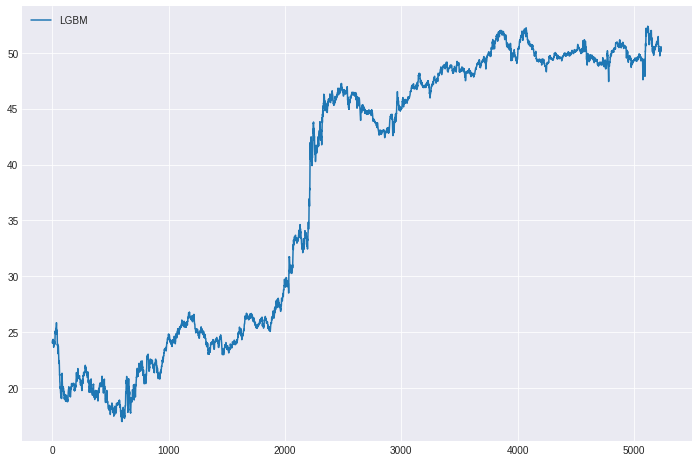

In [95]:
plt.figure(figsize=(12, 8))
plt.plot(V_BN, label='LGBM')
plt.legend()
plt.show()

In [132]:
# define strategy lists
strategy_labels = [
    'LGBM',
]
strategies = [V_BN]
differences = [np.diff(V_BN)]
precisions = [BN_precision]

# create dict and df
res = {
    'Strategy': strategy_labels,
    'Mean': [get_annualized_mean(e) for e in strategies],
    'Volatility': [get_annualized_volatility(e) for e in strategies],
    'Sharpe Ratio': [get_sharpe(e) for e in strategies],
    'Win percentage': [get_win_percentage(diff) for diff in differences],
    'Average precision': [np.mean(pre) * 100 for pre in precisions]
}
df_6c = pd.DataFrame(res).set_index('Strategy').round(4)

# print results
df_6c

,Mean,Volatility,Sharpe Ratio,Win percentage,Average precision
Strategy,,,,,
LGBM,1.2658,3.179,0.3982,50.2579,50.5069


# Final Results
**Note:** 
the neural networks have been trained sequentially, i.e., by online learning. This means that we do not train with rolling windows as in the other models. (However, it proved that it was a poor choice since the nets performed poorly...)

## Portfolio Evolution (Plot)

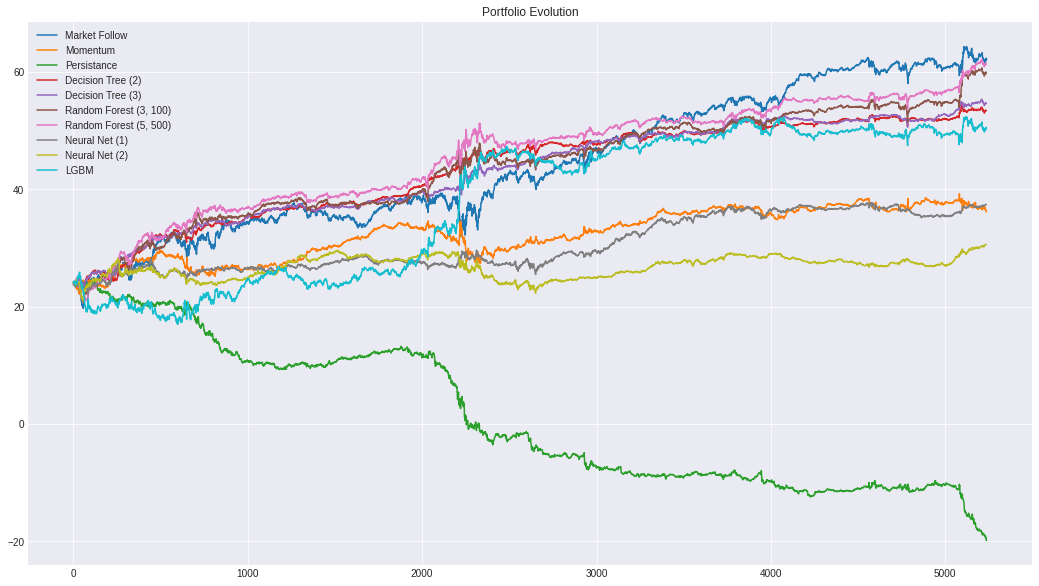

In [100]:
plt.figure(figsize=(18, 10))
plt.plot(V_market_follow, label='Market Follow')
plt.plot(V_momentum, label='Momentum')
plt.plot(V_persistance, label='Persistance')
plt.plot(V_tree_2, label='Decision Tree (2)')
plt.plot(V_tree_3, label='Decision Tree (3)')
plt.plot(V_RF_1, label='Random Forest (3, 100)')
plt.plot(V_RF_2, label='Random Forest (5, 500)')
plt.plot(V_NN_1, label='Neural Net (1)')
plt.plot(V_NN_2, label='Neural Net (2)')
plt.plot(V_BN, label='LGBM')
plt.title('Portfolio Evolution')
plt.legend()
plt.show()

## Portfolio Evolution (Table)

In [128]:
pd.concat([res_2b, res_3b, res_4b, res_5b, res_6b], axis=1)

,Linear regression,Decision tree (Max depth = 2),Decision tree (Max depth = 3),Linear regression,Decision tree (Max depth = 2),Decision tree (Max depth = 3),"Random Forest (Max depth = 3), 100 trees","Random Forest (Max depth = 5), 500 trees",NN-1,NN-2,LGBM
Day,,,,,,,,,,,
0,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00
250,21.86,24.72,26.14,21.86,24.72,26.14,26.86,26.86,26.72,27.87,20.30
500,25.38,32.23,32.05,25.38,32.23,32.05,30.19,31.80,25.10,24.90,17.90
750,28.42,33.69,34.04,28.42,33.69,34.04,34.77,36.27,26.34,24.09,21.92
1000,32.14,35.32,35.14,32.14,35.32,35.14,35.72,36.82,26.74,25.06,24.62
1250,32.17,36.93,37.26,32.17,36.93,37.26,38.13,39.16,26.98,27.75,24.93
1500,29.77,37.34,36.96,29.77,37.34,36.96,37.26,38.81,27.65,29.34,23.71
1750,30.03,38.33,37.88,30.03,38.33,37.88,37.56,39.90,27.24,27.58,25.47
2000,30.65,40.61,39.58,30.65,40.61,39.58,39.82,41.80,27.40,28.92,29.48


## Key Measures

In [135]:
pd.concat([df_2c, df_3c, df_4c, df_5c, df_6c], axis=0)

,Mean,Volatility,Sharpe Ratio,Win percentage,Average precision
Strategy,,,,,
Market follow,1.8428,3.6061,0.5110,54.4396,50.6357
Momentum,0.5851,2.2359,0.2617,53.1602,56.4008
Persistance,-2.1092,2.2942,-0.9193,49.5131,51.8872
Linear regression,0.9175,1.9650,0.4669,50.1624,49.7971
Decision tree (Max depth = 2),1.4230,1.5644,0.9096,51.9580,50.1958
Decision tree (Max depth = 3),1.4709,1.5006,0.9802,51.5568,50.2825
"Random Forest (Max depth = 3), 100 trees",1.7273,2.3966,0.7207,52.9131,51.0067
"Random Forest (Max depth = 5), 500 trees",1.7939,2.5215,0.7115,52.7412,50.9382
NN-1,0.6510,1.7426,0.3736,52.3209,50.6844
